In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 기본 한글 폰트 설정 (시각화 한글 깨짐 방지)
plt.rcParams['font.family'] = 'Malgun Gothic'
# 마이너스 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

# 2번컬럼
- 자치구마다의 빈대여소 / 자치구 전체 대여소
- 빈대여소의 비율을 통해서 자치구마다 따릉이 수요 불균형 파악
- 빈대여소 비율이 높으면 높을 수록 수요 불균형

In [3]:
df = pd.read_csv("./data/working/대여소별_대여가능_수량_1시간단위_w_자치구_최종본.csv")

In [4]:
df.head()

,대여소자치구,대여소번호,일시,시간대,거치대수량
0,강남구,2301,2024-06-01,0,6
1,강남구,2301,2024-06-01,1,8
2,강남구,2301,2024-06-01,2,7
3,강남구,2301,2024-06-01,3,6
4,강남구,2301,2024-06-01,4,6


In [7]:
df.shape

(1704144, 5)

- 총 대여소번호는 2731
- 일시는 26일치 -> 점검이나 측정오류로 인해 결측치가 너무 많은 날짜는 삭제
- 0-24시까지 24시간

In [10]:
df["대여소번호"].nunique(), df["일시"].nunique(), df["시간대"].nunique()

(2731, 26, 24)

- total_counts : 자치구마다의 대여소의 수
- empty_counts : 자치구마다의 시간대 별 자전거의 수가 0인 대여소의 수

In [13]:
# 자치구마다 대여소의 수
total_counts = df.groupby(["대여소자치구", "일시", "시간대"])["대여소번호"].nunique()

In [15]:
# 자치구마다의 시간대 별 자전거의 수가 0인 대여소의 수
empty_counts = (
    df[df["거치대수량"] == 0].groupby(["대여소자치구", "일시", "시간대"])["대여소번호"].nunique()
)

In [17]:
empty_counts

대여소자치구  일시          시간대
강남구     2024-06-01  0      53
                    1      49
                    2      59
                    3      57
                    4      57
                           ..
중랑구     2024-06-30  19      4
                    20      5
                    21      3
                    22      3
                    23      2
Name: 대여소번호, Length: 15562, dtype: int64

In [19]:
# 자치구-시간마다 빈대여소의 수, 자치구마다의 전체 대여소의 수를 데이터프레임으로 만듦
ratio = (
    pd.DataFrame({
        "빈대여소수" : empty_counts,
        "자치구별대여소수" : total_counts
    }).reset_index()
)

In [21]:
# 빈 대여소의 수 / 자치구별 대여소수를 통해 빈대여소비율 칼럼 생성
ratio["빈대여소비율"] = ratio["빈대여소수"] / ratio["자치구별대여소수"]

In [23]:
# 자치구-시간별로 그룹화 시켜서 time_ratio라는 데이터프레임을 생성
time_ratio = ratio.groupby(["대여소자치구", "시간대"])["빈대여소비율"].mean().reset_index(name = "빈대여소비율")

In [25]:
time_ratio = time_ratio.rename(columns={
    "활성시간" : "시간_구분",
    "대여소자치구" : "자치구"
})

In [27]:
time_ratio

,자치구,시간대,빈대여소비율
0,강남구,0,0.237701
1,강남구,1,0.232335
2,강남구,2,0.235912
3,강남구,3,0.232111
4,강남구,4,0.226744
...,...,...,...
595,중랑구,19,0.067103
596,중랑구,20,0.067103
597,중랑구,21,0.065876
598,중랑구,22,0.072831


In [29]:
# 활성시간, 비활성시간, 중간시간으로 나눔
act = {8, 16, 17, 18, 19, 20}
mid = {0, 6, 7, 9, 10, 11, 12, 13, 14, 15, 21, 22}
no_act = {1, 2, 3, 4, 5, 23}

In [31]:
# 활성시간 컬럼을 맵핑
def bucket(h):
    if h in act:
        return "활성"
    elif h in no_act:
        return "비활성"
    else:
        return "중간"

In [33]:
time_ratio["시간_구분"] = time_ratio["시간대"].map(bucket)

In [35]:
time_ratio

,자치구,시간대,빈대여소비율,시간_구분
0,강남구,0,0.237701,중간
1,강남구,1,0.232335,비활성
2,강남구,2,0.235912,비활성
3,강남구,3,0.232111,비활성
4,강남구,4,0.226744,비활성
...,...,...,...,...
595,중랑구,19,0.067103,활성
596,중랑구,20,0.067103,활성
597,중랑구,21,0.065876,중간
598,중랑구,22,0.072831,중간


In [37]:
cols = time_ratio.columns.tolist()

# "활성시간"을 빼고 맨 앞(0번 인덱스) 뒤에 넣기
cols.remove("시간_구분")
cols.insert(1, "시간_구분")

# 새로운 컬럼 순서 적용
time_ratio = time_ratio[cols]

In [39]:
time_ratio = (
    time_ratio
    .groupby(["자치구", "시간_구분"])["빈대여소비율"]
    .agg(빈대여소의비율="mean", std="std")
    .reset_index()
)

In [41]:
time_ratio

,자치구,시간_구분,빈대여소의비율,std
0,강남구,비활성,0.232707,0.005929
1,강남구,중간,0.207793,0.028967
2,강남구,활성,0.216570,0.037731
3,강동구,비활성,0.110790,0.006921
4,강동구,중간,0.085234,0.009674
...,...,...,...,...
70,중구,중간,0.350187,0.115459
71,중구,활성,0.326923,0.081567
72,중랑구,비활성,0.072149,0.002295
73,중랑구,중간,0.083061,0.011130


In [43]:
컬럼2_활성시간 = time_ratio[time_ratio["시간_구분"] == "활성"]

In [45]:
컬럼2_비활성시간 = time_ratio[time_ratio["시간_구분"] == "비활성"]

In [47]:
컬럼2_중간시간 = time_ratio[time_ratio["시간_구분"] == "중간"]

# 활성시간때의 비율 시각화
- 중구, 종로구, 용산구 순으로 높음

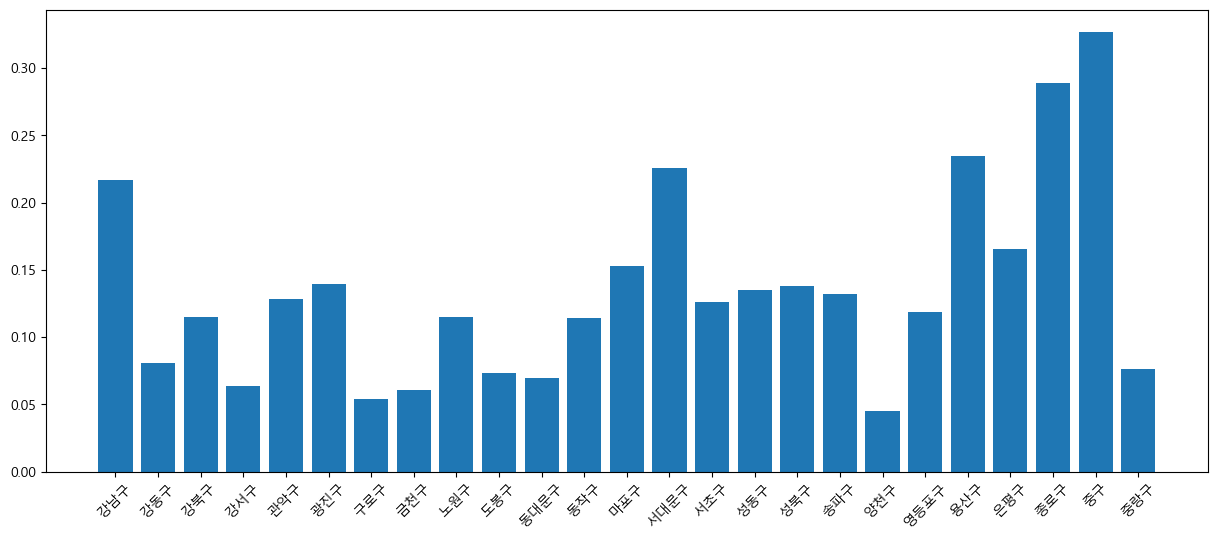

In [50]:
plt.figure(figsize = (15, 6))
plt.bar(컬럼2_활성시간["자치구"], 컬럼2_활성시간["빈대여소의비율"])
plt.xticks(rotation = 45)

plt.show()

# 비활성시간때의 비율 시각화
- 중구, 종로구, 용산구순으로 높음

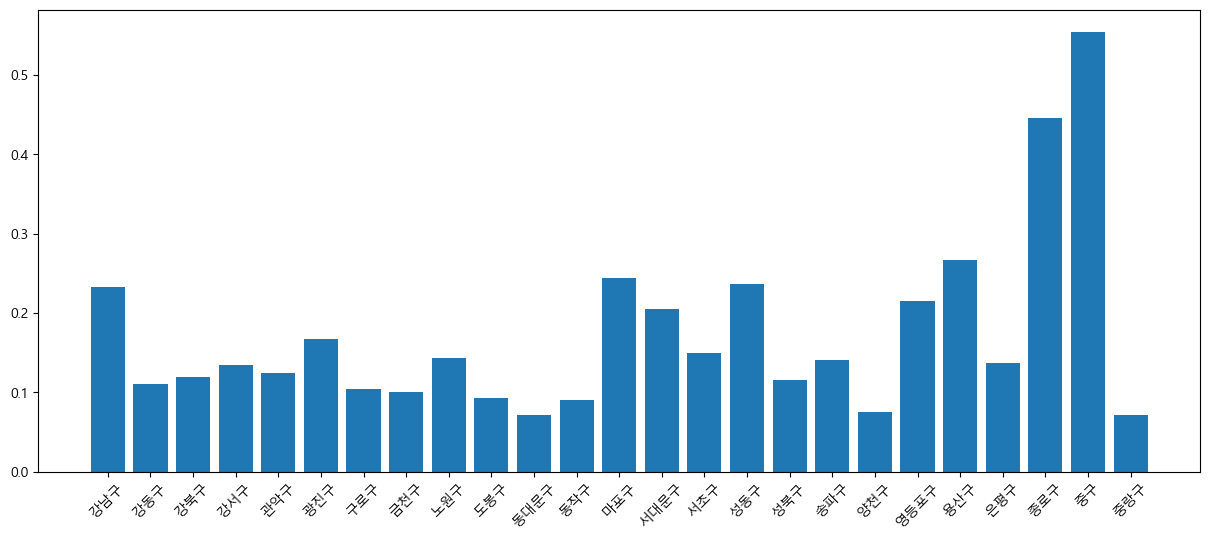

In [53]:
plt.figure(figsize = (15, 6))
plt.bar(컬럼2_비활성시간["자치구"], 컬럼2_비활성시간["빈대여소의비율"])
plt.xticks(rotation = 45)

plt.show()

# 중간시간때의 빈 대여소의 비율
- 중구, 종로구, 용산구, 서대문구 순으로 높음

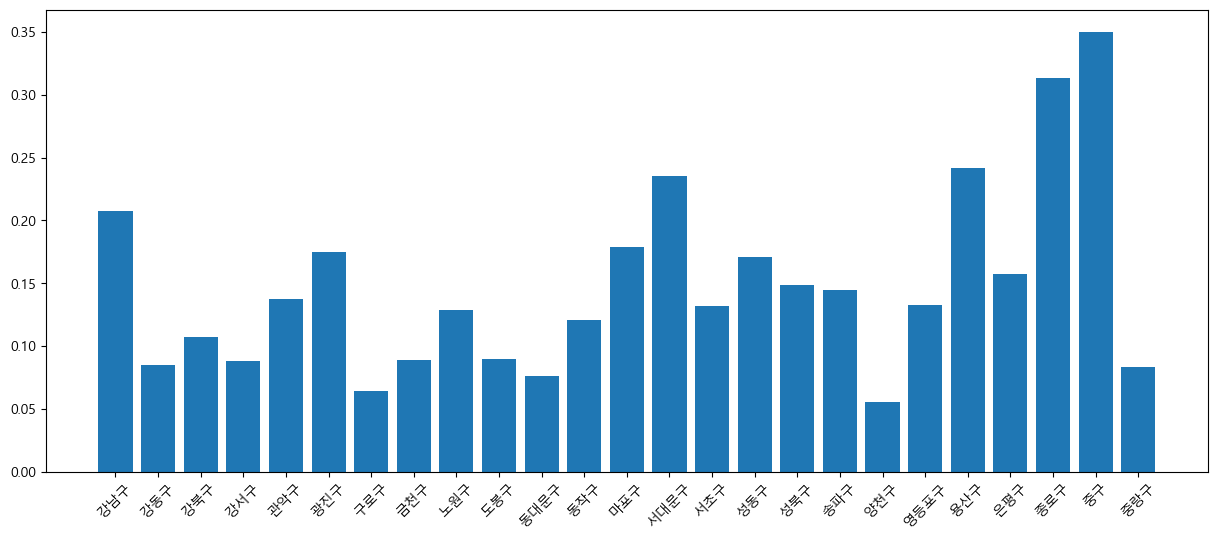

In [56]:
plt.figure(figsize = (15, 6))
plt.bar(컬럼2_중간시간["자치구"], 컬럼2_중간시간["빈대여소의비율"])
plt.xticks(rotation = 45)

plt.show()

# 3번 컬럼
- 각 자치구마다의 빈 대여소가 몇시간 존재하는지의 합
- 빈대여소의 시간이 크면 클 수록 따릉이의 수요 불균형이라고 판단

In [59]:
# 자치구, 시간대로 그룹화 시킨 거치대의 수량(한시간마다의 빈대여소를 알려줌)을 카운팅하고 데이터프레임으로 만듦
empty_time = (
    df[df["거치대수량"] == 0]           # 빈 대여소만 필터링
    .groupby(["대여소자치구", "시간대"])["거치대수량"]
    .count()                           # 행 개수 세기
    .reset_index(name="빈대여소_횟수")   # 컬럼 이름 바꾸기
)

In [61]:
empty_time = empty_time.rename(columns={
    "활성시간" : "시간_구분",
    "대여소자치구" : "자치구"
})

In [63]:
empty_time

,자치구,시간대,빈대여소_횟수
0,강남구,0,1063
1,강남구,1,1039
2,강남구,2,1055
3,강남구,3,1038
4,강남구,4,1014
...,...,...,...
595,중랑구,19,164
596,중랑구,20,164
597,중랑구,21,161
598,중랑구,22,178


In [65]:
# 활성시간 맵핑
empty_time["시간_구분"] = empty_time["시간대"].map(bucket)

In [67]:
empty_time

,자치구,시간대,빈대여소_횟수,시간_구분
0,강남구,0,1063,중간
1,강남구,1,1039,비활성
2,강남구,2,1055,비활성
3,강남구,3,1038,비활성
4,강남구,4,1014,비활성
...,...,...,...,...
595,중랑구,19,164,활성
596,중랑구,20,164,활성
597,중랑구,21,161,중간
598,중랑구,22,178,중간


In [69]:
cols = empty_time.columns.tolist()

# "활성시간"을 빼고 맨 앞(0번 인덱스) 뒤에 넣기
cols.remove("시간_구분")
cols.insert(1, "시간_구분")

# 새로운 컬럼 순서 적용
empty_time = empty_time[cols]

In [71]:
empty_time = empty_time.groupby(["자치구", "시간_구분"])["빈대여소_횟수"].sum().reset_index(name = "빈대여소시간")

In [73]:
empty_time

,자치구,시간_구분,빈대여소시간
0,강남구,비활성,6244
1,강남구,중간,11151
2,강남구,활성,5811
3,강동구,비활성,1953
4,강동구,중간,3005
...,...,...,...
70,중구,중간,9724
71,중구,활성,4539
72,중랑구,비활성,1058
73,중랑구,중간,2436


In [75]:
컬럼3_활성시간 = empty_time[empty_time["시간_구분"] == "활성"]
컬럼3_비활성시간 = empty_time[empty_time["시간_구분"] == "비활성"]
컬럼3_중간시간 = empty_time[empty_time["시간_구분"] == "중간"]

# 활성시간때의 빈대여소의 시간
- 강남구, 종로구, 중구 순으로 높음

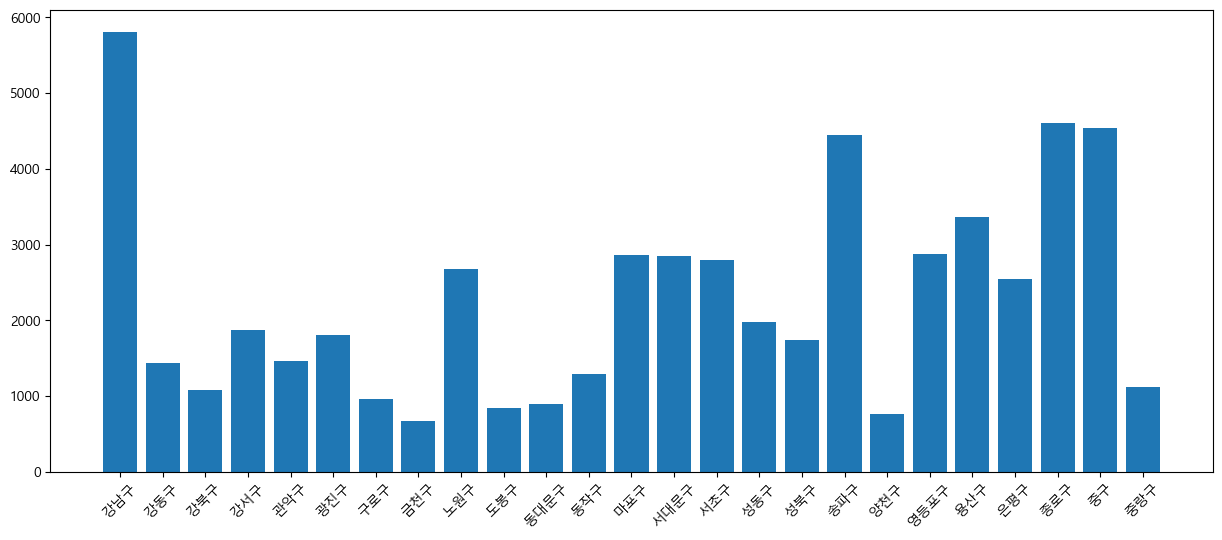

In [78]:
plt.figure(figsize = (15, 6))
plt.bar(컬럼3_활성시간["자치구"], 컬럼3_활성시간["빈대여소시간"])
plt.xticks(rotation = 45)

plt.show()

# 비활성시간때의 빈대여소의 시간
- 중구, 종로구, 강남구 순으로 높음

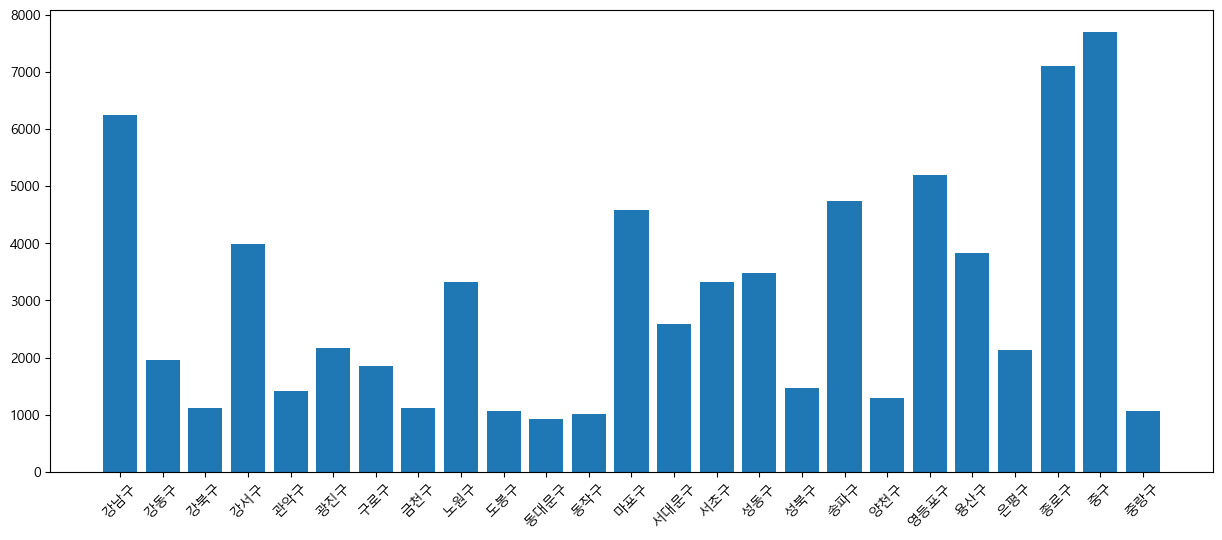

In [81]:
plt.figure(figsize = (15, 6))
plt.bar(컬럼3_비활성시간["자치구"], 컬럼3_비활성시간["빈대여소시간"])
plt.xticks(rotation = 45)

plt.show()

# 중간시간때의 빈대여소의 시간
- 강남구, 종로구, 송팜구 순으로 높음

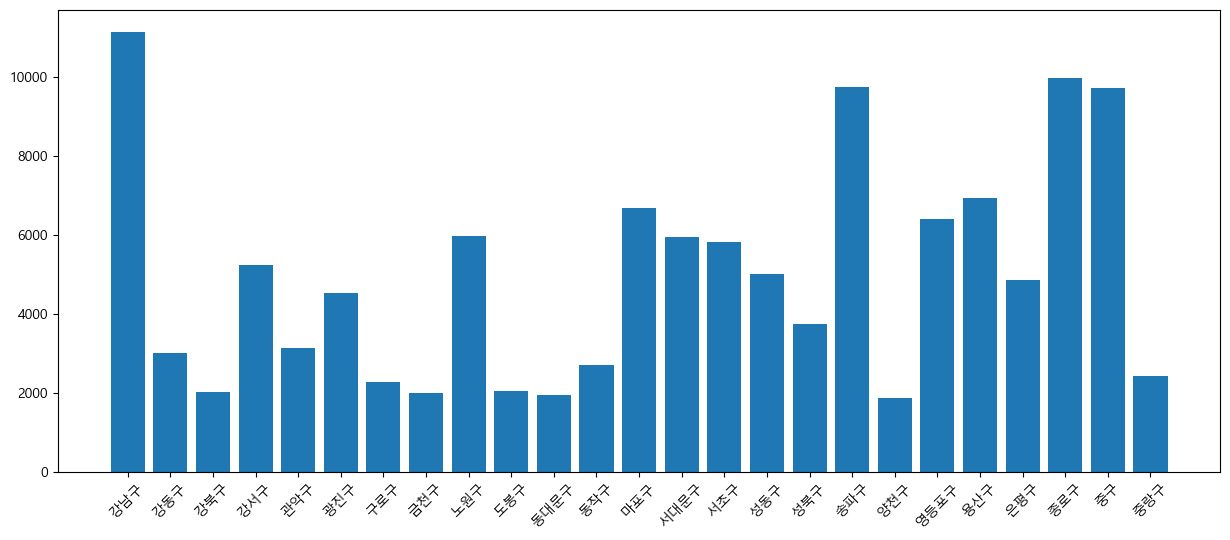

In [86]:
plt.figure(figsize = (15, 6))
plt.bar(컬럼3_중간시간["자치구"], 컬럼3_중간시간["빈대여소시간"])
plt.xticks(rotation = 45)

plt.show()

In [88]:
컬럼2_활성시간.to_csv("./data/columns/컬럼2_활성시간.csv", index = False)
컬럼2_비활성시간.to_csv("./data/columns/컬럼2_비활성시간.csv", index = False)
컬럼2_중간시간.to_csv("./data/columns/컬럼2_중간시간.csv", index = False)

In [90]:
컬럼3_활성시간.to_csv("./data/columns/컬럼3_활성시간.csv", index = False)
컬럼3_비활성시간.to_csv("./data/columns/컬럼3_비활성시간.csv", index = False)
컬럼3_중간시간.to_csv("./data/columns/컬럼3_중간시간.csv", index = False)